# Tratamento de dados - Secretaria de segurança do estado do Paraná

## Descrição do notebook

O objetivo desse notebook é realizar o tratamento dos dados fornecidos pela Secretaria de Segurança Pública do Estado do Paraná para que possa ser analisado juntamente com os dados do estado paraens.

Nessa versão, são utilizados quatro arquivos do tipo CSV e para manipulação de dados é utilizado o pacote pyspark.

**Observação:** O código contido nesse notebook foi baseado na solução desenvolvida por Mariana Kniss (https://www.linkedin.com/in/mariana-kniss-471ba0196/), para validar o conteúdo de seu trabalho de conclusão de curso, intitulado "ANÁLISE DE DADOS CRIMINAIS SOBRE VIOLÊNCIA CONTRA A MULHER NOS ESTADOS PARÁ E PARANÁ".

## Sumário

1. [Importação dos módulos e pacotes necessários](#importacao-dos-modulos-e-pacotes-necessarios)
2. [Carregamento dos dados](#carregamento-dos-dados)
4. [Visão geral do conjunto de dados](#visao-geral-do-conjunto-de-dados)
5. [Filtros, tratamentos e padronização de valores](#filtros-tratamentos-e-padronizacao-de-valores)
6. [Ordenação das colunas](#ordernacao-das-colunas)
7. [Exportação dos dados formatados](#exportacao-dos-dados-formatados)

----


## Importação dos módulos e pacotes necessários <a id="importacao-dos-modulos-e-pacotes-necessarios"></a>

In [1]:
# pySpark (https://spark.apache.org/docs/latest/api/python/index.html)
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col, lower, when, substring, hour, to_timestamp, date_format, count, current_date, datediff, mean, median, variance, stddev,  collect_list, first, regexp_replace, lit, split, upper
from pyspark.sql.types import StringType, StructType, StructField, DateType
from pyspark.ml import stat

In [2]:
# Criando sessão spark
spark = SparkSession.builder\
    .master('local[*]')\
    .appName('transformacao_VCM_PR')\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/08 09:29:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Carregamento dos dados

In [3]:
# Dados sobre as ocorrências
ocorrencias = spark.read.csv('./dados/PR/Ocorrencias de ViolDom ContraMulher (Jan2018-Ago2023) PR.csv',
                       sep = ';',
                       inferSchema= True,
                       header = True)

In [4]:
# Dados sobre as naturezas
naturezas = spark.read.csv('./dados/PR/Naturezas das Ocorrencias de ViolDom ContraMulher (Jan2018-Ago2023) PR.csv',
                       sep = ';',
                       inferSchema= True,
                       header = True)

In [5]:
# Dados sobre as vítimas
vitimas = spark.read.csv('./dados/PR/Vitimas das Ocorrencias de ViolDom ContraMulher (Jan2018-Ago2023) PR.csv',
                       sep = ';',
                       inferSchema= True,
                       header = True)

In [6]:
# Dados sobre os autores
autores = spark.read.csv('./dados/PR/Autores das Ocorrencias de ViolDom ContraMulher (Jan2018-Ago2023) PR.csv',
                       sep = ';',
                       inferSchema= True,
                       header = True)

Contagem dos registros carregados.

In [7]:
print(f'Foram encontradas {ocorrencias.count()} ocorrências.')
print(f'Foram encontradas {naturezas.select("id_boletim").distinct().count()} naturezas.')
print(f'Foram encontradas {vitimas.select("id_boletim").distinct().count()} vítimas.')
print(f'Foram encontradas {autores.select("id_boletim").distinct().count()} autores.')



Foram encontradas 340478 ocorrências.


Foram encontradas 340478 naturezas.


Foram encontradas 340479 vítimas.
Foram encontradas 9869 autores.


## Agrupamento dos dados

In [8]:
agrupado_df = naturezas.groupBy("id_boletim").agg(collect_list("registros").alias("registros_unicos"))
agrupado_df.show(truncate=False)

+----------+------------------------------------------------------------------------+
|id_boletim|registros_unicos                                                        |
+----------+------------------------------------------------------------------------+
|202088    |[LESAO CORPORAL - VIOLENCIA DOMESTICA E FAMILIAR]                       |
|2018348   |[LESAO CORPORAL - VIOLENCIA DOMESTICA E FAMILIAR]                       |
|2018452   |[NOTICIA DE FATO FUTURO]                                                |
|2018453   |[AMEACA]                                                                |
|2018501   |[LESAO CORPORAL - VIOLENCIA DOMESTICA E FAMILIAR]                       |
|2018576   |[LESAO CORPORAL - VIOLENCIA DOMESTICA E FAMILIAR]                       |
|2018612   |[VIAS DE FATO]                                                          |
|2018695   |[AMEACA]                                                                |
|2018701   |[AMEACA, LESAO CORPORAL]                  

In [9]:
agrupado_df.count()

340478

In [10]:
naturezas.select("registros").distinct().count()

311

In [11]:
naturezas.select("classe_motivo").distinct().count()

56

In [12]:
naturezas.select("classe_motivo").distinct().show(truncate=False)

+---------------------------------------------------+
|classe_motivo                                      |
+---------------------------------------------------+
|CRIMES CONTRA A INVIOLABILIDADE DOS SEGREDOS       |
|LEI 4.898/65 - ABUSO DE AUTORIDADE                 |
|LEI 10.741/03 - ESTATUTO DO IDOSO                  |
|LEI 5.553/68 - APRESENTACAO E USO DE DOCUMENTOS    |
|LEI Nº 11.829, DE 25 DE NOVEMBRO DE 2008           |
|LEI 8.072/90 - CRIMES HEDIONDOS                    |
|LEI 2.252/54 - CORRUPCAO DE MENORES                |
|CRIMES CONTRA A ORGANIZACAO DO TRABALHO            |
|LEI 8.078/90 - CRIMES CONTRA O CONSUMIDOR          |
|LEI 9.455/97 - CRIMES DE TORTURA                   |
|LEI 3.688/41 - CONTRAVENCOES PENAIS                |
|LEI 11343 - NOVA LEI DE TOXICOS                    |
|8.666/93 - LICITACOES                              |
|OCORRENCIAS NAO DELITUOSAS                         |
|CRIMES CONTRA A ADMINISTRACAO DA JUSTICA           |
|LEI 8.069/90 - ESTATUTO DA 

In [13]:
naturezas_feminicidio = naturezas.filter(lower(col('registros')).like('feminicidio'))
naturezas_feminicidio.count() 

201

In [14]:
# Selecionando a base de VCM com base na variavel 'classe_motivo', utilizando como filtro as palavras chave
palavras_chave = ["mulher", "sexual", "medidas protetivas", "13772"]
naturezas = naturezas.filter(lower(col("classe_motivo")).like("%" + palavras_chave[0] + "%")
                                   | lower(col("classe_motivo")).like("%" + palavras_chave[1] + "%")
                                   | lower(col("classe_motivo")).like("%" + palavras_chave[2] + "%")
                                   | lower(col("classe_motivo")).like("%" + palavras_chave[3] + "%"))

# Exibindo o dataset VCM
naturezas.show()

+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id_boletim|      data_registro|hora_registro|          data_fato|dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|    distrito|        municipio|    regional|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|
+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------

In [15]:
naturezas.count()

22095

In [16]:
naturezas.select("id_boletim").distinct().count()

21884

In [17]:
len(naturezas.columns)

22

In [18]:
naturezas_unique = naturezas.groupBy("id_boletim").agg(
    first("data_registro").alias("data_registro"),
    first("hora_registro").alias("hora_registro"),
    first("data_fato").alias("data_fato"),
    first("dia_semana").alias("dia_semana"),
    first("hora_fato").alias("hora_fato"),
    first("fx_4_hr").alias("fx_4_hr"),
    first("fx_12_hr").alias("fx_12_hr"),
    first("mes_registro").alias("mes_registro"),
    first("mes_fato").alias("mes_fato"),
    first("ano_registro").alias("ano_registro"),
    first("ano_fato").alias("ano_fato"),
    first("causa_presumivel").alias("causa_presumivel"),
    first("distrito").alias("distrito"),
    first("municipio").alias("municipio"),
    first("regional").alias("regional"),
    first("bairro").alias("bairro"),
    first("identificacao_fato").alias("identificacao_fato"),
    first("local_ocorrencia").alias("local_ocorrencia"),
    first("meio_empregado").alias("meio_empregado"),
    first("classe_motivo").alias("classe_motivo"),
    collect_list("registros").alias("registros_unicos")
)

In [19]:
naturezas_unique.show()

24/02/08 09:32:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+-------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|id_boletim|      data_registro|hora_registro|          data_fato|dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|    distrito|          municipio|    regional|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|    registros_unicos|
+----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+-------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------

In [20]:
len(naturezas_unique.columns)

22

In [21]:
naturezas_unique.count()

21884

In [22]:
naturezas_unique.printSchema()

root
 |-- id_boletim: long (nullable = true)
 |-- data_registro: timestamp (nullable = true)
 |-- hora_registro: integer (nullable = true)
 |-- data_fato: timestamp (nullable = true)
 |-- dia_semana: string (nullable = true)
 |-- hora_fato: integer (nullable = true)
 |-- fx_4_hr: string (nullable = true)
 |-- fx_12_hr: string (nullable = true)
 |-- mes_registro: integer (nullable = true)
 |-- mes_fato: integer (nullable = true)
 |-- ano_registro: integer (nullable = true)
 |-- ano_fato: integer (nullable = true)
 |-- causa_presumivel: string (nullable = true)
 |-- distrito: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- regional: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- identificacao_fato: string (nullable = true)
 |-- local_ocorrencia: string (nullable = true)
 |-- meio_empregado: string (nullable = true)
 |-- classe_motivo: string (nullable = true)
 |-- registros_unicos: array (nullable = false)
 |    |-- element: string (containsNul

In [23]:
from pyspark.sql.functions import concat_ws

# # Crie uma sessão do Spark
# spark = SparkSession.builder.appName("exemplo").getOrCreate()

# # Suponha que você tenha um DataFrame chamado df com uma coluna chamada 'coluna_array'
# # que contém arrays que você deseja converter para strings

# # Exemplo de dados
# dados = [("linha1", [1, 2, 3]),
#          ("linha2", [4, 5, 6]),
#          ("linha3", [7, 8, 9])]

# # Defina o esquema do DataFrame
# esquema = ["id", "coluna_array"]

# # Crie o DataFrame
# df = spark.createDataFrame(dados, esquema)

# Use a função concat_ws para converter a coluna de array para string
df_resultado = naturezas_unique.withColumn("registros", concat_ws(",", naturezas_unique["registros_unicos"]))

# Mostre o resultado
df_resultado.show()

+----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+-------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|id_boletim|      data_registro|hora_registro|          data_fato|dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|    distrito|          municipio|    regional|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|    registros_unicos|           registros|
+----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+-------------------+------------+--------------------+--------------------+--------------------+--------

In [24]:
df_resultado.printSchema()

root
 |-- id_boletim: long (nullable = true)
 |-- data_registro: timestamp (nullable = true)
 |-- hora_registro: integer (nullable = true)
 |-- data_fato: timestamp (nullable = true)
 |-- dia_semana: string (nullable = true)
 |-- hora_fato: integer (nullable = true)
 |-- fx_4_hr: string (nullable = true)
 |-- fx_12_hr: string (nullable = true)
 |-- mes_registro: integer (nullable = true)
 |-- mes_fato: integer (nullable = true)
 |-- ano_registro: integer (nullable = true)
 |-- ano_fato: integer (nullable = true)
 |-- causa_presumivel: string (nullable = true)
 |-- distrito: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- regional: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- identificacao_fato: string (nullable = true)
 |-- local_ocorrencia: string (nullable = true)
 |-- meio_empregado: string (nullable = true)
 |-- classe_motivo: string (nullable = true)
 |-- registros_unicos: array (nullable = false)
 |    |-- element: string (containsNul

In [25]:
df_resultado.count()

21884

In [26]:
len(df_resultado.columns)

23

In [27]:
naturezas_unique = df_resultado.drop('registros_unicos')

In [28]:
len(naturezas_unique.columns)

22

In [29]:
naturezas_feminicidio.printSchema()

root
 |-- id_boletim: long (nullable = true)
 |-- data_registro: timestamp (nullable = true)
 |-- hora_registro: integer (nullable = true)
 |-- data_fato: timestamp (nullable = true)
 |-- dia_semana: string (nullable = true)
 |-- hora_fato: integer (nullable = true)
 |-- fx_4_hr: string (nullable = true)
 |-- fx_12_hr: string (nullable = true)
 |-- mes_registro: integer (nullable = true)
 |-- mes_fato: integer (nullable = true)
 |-- ano_registro: integer (nullable = true)
 |-- ano_fato: integer (nullable = true)
 |-- causa_presumivel: string (nullable = true)
 |-- distrito: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- regional: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- identificacao_fato: string (nullable = true)
 |-- local_ocorrencia: string (nullable = true)
 |-- meio_empregado: string (nullable = true)
 |-- classe_motivo: string (nullable = true)
 |-- registros: string (nullable = true)



In [30]:
# Use a função 'union' para unir os DataFrames
naturezas_union = naturezas_unique.union(naturezas_feminicidio)

# Exiba o DataFrame resultante
naturezas_union.count()

22085

In [31]:
naturezas_unique = naturezas_union

In [32]:
naturezas_unique.select("classe_motivo").distinct().count()

5

In [33]:
#naturezas_unique.select("registros_unicos").distinct().count()

In [34]:
naturezas_unique.select("classe_motivo").distinct().show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+
|classe_motivo                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------+
|CRIMES CONTRA A DIGNIDADE SEXUAL                                                                                               |
|LEI 11340/06 - CRIA MECANISMOS PARA COIBIR A VIOLENCIA DOMESTICA E FAMILIAR CONTRA A MULHER                                    |
|LEI 13.641/18 - DO CRIME DE DESCUMPRIMENTO DE MEDIDAS PROTETIVAS DE URGENCIA - DESCUMPRIMENTO DE MEDIDAS PROTETIVAS DE URGENCIA|
|LEI Nº 13772 DE DEZEMBRO DE 2018                                                                                               |
|CRIMES CONTRA A PESSOA                                                                   

In [35]:
#agrupando os dados por registros_unicos, mostrando todas as categorias possiveis
#naturezas_unique.groupBy("registros_unicos").count().orderBy(col("count").desc()).show(naturezas_unique.count(), truncate=False)

In [36]:
naturezas_nao_unicos = naturezas.groupBy("id_boletim").count().orderBy(col("id_boletim").desc())
naturezas_nao_unicos.filter(naturezas_nao_unicos["count"] == 3).show()

+-----------+-----+
| id_boletim|count|
+-----------+-----+
|20201001697|    3|
| 2021690926|    3|
| 2021189650|    3|
+-----------+-----+



In [37]:
naturezas.filter(naturezas['id_boletim'] == "20201001697").show(truncate=False)

+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+---------+------------+------------+---------------------------------+----------------+---------------+--------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id_boletim |data_registro      |hora_registro|data_fato          |dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|distrito    |municipio|regional    |bairro      |identificacao_fato               |local_ocorrencia|meio_empregado |c

In [38]:
naturezas_unique.filter(naturezas_unique['id_boletim'] == "20201001697").show(truncate=False)

+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+---------+------------+------------+---------------------------------+----------------+---------------+--------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id_boletim |data_registro      |hora_registro|data_fato          |dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|distrito    |municipio|regional    |bairro      |identificaca

In [39]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine todos os valores de 'registros_unicos' em uma única string
texto_registros = " ".join(naturezas_unique.rdd.flatMap(lambda x: x["registros_unicos"]).collect())

# Crie a nuvem de palavras
nuvem_palavras = WordCloud(width=800, height=400, background_color='white').generate(texto_registros)

# Exiba a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(nuvem_palavras, interpolation="bilinear")
plt.axis("off")
plt.show()

24/02/08 09:34:01 ERROR Executor: Exception in task 2.0 in stage 118.0 (TID 159)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 2364, in __getitem__
    idx = self.__fields__.index(item)
ValueError: 'registros_unicos' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 118.0 failed 1 times, most recent failure: Lost task 2.0 in stage 118.0 (TID 159) (192.168.1.4 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 2364, in __getitem__
    idx = self.__fields__.index(item)
ValueError: 'registros_unicos' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "/var/folders/ln/_mw0hd8d6ls5z_dsg4468zrh0000gp/T/ipykernel_2738/2974857164.py", line 5, in <lambda>
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 2369, in __getitem__
    raise PySparkValueError(item)
pyspark.errors.exceptions.base.PySparkValueError: registros_unicos

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1046)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 2364, in __getitem__
    idx = self.__fields__.index(item)
ValueError: 'registros_unicos' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "/var/folders/ln/_mw0hd8d6ls5z_dsg4468zrh0000gp/T/ipykernel_2738/2974857164.py", line 5, in <lambda>
  File "/Users/andre/anaconda3/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 2369, in __getitem__
    raise PySparkValueError(item)
pyspark.errors.exceptions.base.PySparkValueError: registros_unicos

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1046)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


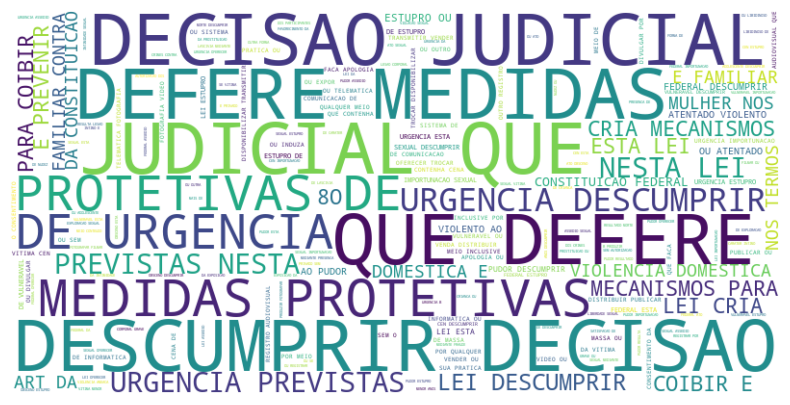

In [ ]:
registros = " ".join(naturezas.select("registros").rdd.flatMap(lambda x: x).collect())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(registros)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
naturezas = naturezas.withColumn("registros", lower(regexp_replace(col("registros"), "[^a-zA-Z ]", "")))

contagem_judicial = naturezas.filter(naturezas.registros.contains("judicial")).count()
contagem_estupro = naturezas.filter(naturezas.registros.contains("estupro")).count()

print("Número de ocorrências da palavra 'judicial':", contagem_judicial)
print("Número de ocorrências da palavra 'estupro':", contagem_estupro)


Número de ocorrências da palavra 'judicial': 15473
Número de ocorrências da palavra 'estupro': 2400


In [ ]:
cloud = naturezas.filter(
    (naturezas.registros != 'DESCUMPRIR DECISAO JUDICIAL QUE DEFERE MEDIDAS PROTETIVAS DE URGENCIA') &
    (naturezas.registros != 'DESCUMPRIR DECISAO JUDICIAL QUE DEFERE MEDIDAS PROTETIVAS DE URGENCIA PREVISTAS NESTA LEI') &
    (naturezas.registros != 'ESTA LEI CRIA MECANISMOS PARA COIBIR E PREVENIR A ')
)

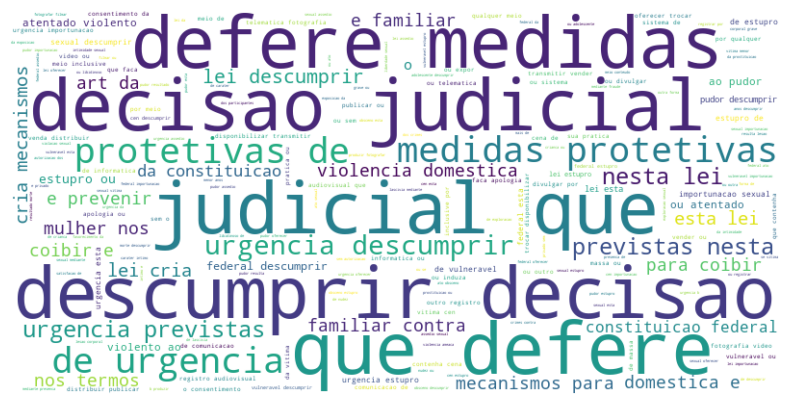

In [ ]:
registros = " ".join(cloud.select("registros").rdd.flatMap(lambda x: x).collect())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(registros)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Tentativas de JOIN

In [ ]:
ocorrencias.show()

+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+------------------+------------+-------------------+--------------------+
| id_boletim|      data_registro|hora_registro|          data_fato|dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|    distrito|         municipio|    regional|             bairro|  identificacao_fato|
+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+------------------+------------+-------------------+--------------------+
|20181000026|2018-09-02 00:44:00|            0|2018-09-01 22:05:00|       Sab|       22|  18_23|   20_22|           9|       9|        2018|    2018|    indisponivel|indisponivel|          IVAIPORA|indisponivel|             CENTRO|Violencia_

In [ ]:
len(ocorrencias.columns)

18

In [ ]:
vitimas.show()

+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+------------------+------------+-------------------+--------------------+--------------------+-------------------+---------+-------------+----+-------------+--------------------+--------------------+
| id_boletim|      data_registro|hora_registro|          data_fato|dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|    distrito|         municipio|    regional|             bairro|  identificacao_fato|              vitima|        vit_dt_nasc|vit_idade| faixa_etaria|sexo|     raca_cor|      grau_instrucao|           profissao|
+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+------------------+------------+-------------------+-----------

In [40]:
len(vitimas.columns)

26

In [41]:
dados = vitimas.join(naturezas.select('id_boletim', 'local_ocorrencia', 'meio_empregado', 'classe_motivo', 'registros'), 'id_boletim', 'left')

In [42]:
len(dados.columns)

30

In [43]:
dados.show()

+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+------------------+------------+-------------------+--------------------+--------------------+-------------------+---------+-------------+----+-------------+--------------------+--------------------+----------------+--------------+-------------+---------+
| id_boletim|      data_registro|hora_registro|          data_fato|dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|    distrito|         municipio|    regional|             bairro|  identificacao_fato|              vitima|        vit_dt_nasc|vit_idade| faixa_etaria|sexo|     raca_cor|      grau_instrucao|           profissao|local_ocorrencia|meio_empregado|classe_motivo|registros|
+-----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+---

In [44]:
dados.select('id_boletim').distinct().count()

340479

In [45]:
dados.count()

350459

In [46]:
dados = dados.join(naturezas.select('id_boletim', 'local_ocorrencia', 'meio_empregado', 'classe_motivo', 'registros'), 'id_boletim', 'left')

In [47]:
dados.count()

350903

In [48]:
dados = dados.join(autores.select('id_boletim', 'autor', 'aut_dt_nasc', 'aut_idade', 'faixa_etaria', 'parentesco', 'sexo', 'raca_cor', 'grau_instrucao', 'profissao'), 'id_boletim', 'outer')

In [49]:
dados.count()

351530

In [50]:
dados_VCM = ocorrencias.join(vitimas.select('id_boletim', 'vitima', 'vit_dt_nasc', 'vit_idade', 'faixa_etaria', 'sexo', 'raca_cor', 'grau_instrucao', 'profissao'), 'id_boletim', 'outer')

In [51]:
dados_VCM.count()

350240

In [52]:
dados_VCM = dados_VCM.join(naturezas.select('id_boletim', 'local_ocorrencia', 'meio_empregado', 'classe_motivo', 'registros'), 'id_boletim', 'left')

In [53]:
dados_VCM.show()

+----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+------------------+------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+----+-------------+--------------------+------------------+----------------+--------------+-------------+---------+
|id_boletim|      data_registro|hora_registro|          data_fato|dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|    distrito|         municipio|    regional|              bairro|  identificacao_fato|              vitima|        vit_dt_nasc|vit_idade| faixa_etaria|sexo|     raca_cor|      grau_instrucao|         profissao|local_ocorrencia|meio_empregado|classe_motivo|registros|
+----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+--------

## Novas tentativas de JOIN

In [54]:
naturezas.count()

22095

In [55]:
naturezas_unique.count()

22085

In [56]:
naturezas_vitimas = naturezas_unique.join(vitimas.select('id_boletim', 'vitima', 'vit_dt_nasc', 'vit_idade', 'faixa_etaria', 'raca_cor', 'grau_instrucao', 'profissao'), on='id_boletim')

In [57]:
naturezas_vitimas.count()

22634

In [58]:
naturezas_vitimas.select("id_boletim").distinct().count()

22082

In [59]:
naturezas_vitimas.show()

+----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+-------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+-------------+--------------------+--------------------+
|id_boletim|      data_registro|hora_registro|          data_fato|dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|    distrito|          municipio|    regional|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|              vitima|        vit_dt_nasc|vit_idade| faixa_etaria|     raca_cor|      grau_instrucao|           profissao|
+----------+-------------------+-------------+-------------------+----------+-----

In [60]:
autores = autores \
    .withColumnRenamed("faixa_etaria", "aut_faixa_etaria") \
    .withColumnRenamed("raca_cor", "aut_raca_cor") \
    .withColumnRenamed("grau_instrucao", "aut_grau_instrucao") \
    .withColumnRenamed("profissao", "aut_profissao")

In [61]:
naturezas_vitimas_autores = naturezas_vitimas.join(autores.select('id_boletim', 'autor', 'aut_dt_nasc', 'aut_idade', 'aut_faixa_etaria', 'aut_raca_cor', 'aut_grau_instrucao', 'aut_profissao', 'parentesco'), on='id_boletim', how='left')

In [62]:
naturezas_vitimas_autores.count()

22657

In [63]:
naturezas_vitimas_autores.show()

+----------+-------------------+-------------+-------------------+----------+---------+-------+--------+------------+--------+------------+--------+----------------+------------+-------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+-------------+--------------------+--------------------+-----+-----------+---------+----------------+------------+------------------+-------------+----------+
|id_boletim|      data_registro|hora_registro|          data_fato|dia_semana|hora_fato|fx_4_hr|fx_12_hr|mes_registro|mes_fato|ano_registro|ano_fato|causa_presumivel|    distrito|          municipio|    regional|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|              vitima|        vit_dt_nasc|vit_idade| faixa_etaria|     raca_cor|      grau_instrucao|  

In [64]:
colunas_remover = ['id_boletim', 'fx_4_hr', 'fx_12_hr', 'hora_registro', 'hora_fato', 'causa_presumivel', 'distrito', 'regional', 'vitima']
dados_VCM_PR = naturezas_vitimas_autores.drop(*colunas_remover)

In [65]:
dados_VCM_PR.count()

22657

In [66]:
dados_VCM_PR = dados_VCM_PR.withColumn("estado", lit("PR"))

In [67]:
dados_VCM_PR.show()

+-------------------+-------------------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+--------+--------------------+-----------------+--------------------+-------------------+---------+----------------+------------+------------------+-------------+-------------+------+
|      data_registro|          data_fato|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|        vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|        aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|estado|
+-------------------+-------------------+----------+------

In [68]:
# Duplica as colunas 'data_registro' e 'data_fato' como 'data_registro_dup' e 'data_fato_dup'
dados_VCM_PR = dados_VCM_PR.withColumn("data_registro_dup", col("data_registro"))
dados_VCM_PR = dados_VCM_PR.withColumn("data_fato_dup", col("data_fato"))

In [69]:
# Divida as colunas 'data_registro_dup' e 'data_fato_dup' em duas colunas: data e hora
dados_VCM_PR = dados_VCM_PR.withColumn("data_registro", split(col("data_registro"), " ").getItem(0))
dados_VCM_PR = dados_VCM_PR.withColumn("hora_registro", split(col("data_registro_dup"), " ").getItem(1))
dados_VCM_PR = dados_VCM_PR.withColumn("data_fato", split(col("data_fato"), " ").getItem(0))
dados_VCM_PR = dados_VCM_PR.withColumn("hora_fato", split(col("data_fato_dup"), " ").getItem(1))

In [70]:
dados_VCM_PR.show()

+-------------+----------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+--------+--------------------+-----------------+--------------------+-------------------+---------+----------------+------------+------------------+-------------+-------------+------+-------------------+-------------------+-------------+---------+
|data_registro| data_fato|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|        vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|        aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|estado|  data_registro_dup|     

In [71]:
colunas_remover = ['data_registro_dup', 'data_fato_dup']
dados_VCM_PR = dados_VCM_PR.drop(*colunas_remover)

In [72]:
dados_VCM_PR.show()

+-------------+----------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+--------+--------------------+-----------------+--------------------+-------------------+---------+----------------+------------+------------------+-------------+-------------+------+-------------+---------+
|data_registro| data_fato|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|        vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|        aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|estado|hora_registro|hora_fato|
+-------------+----------+----------+---

In [73]:
len(dados_VCM_PR.columns)

31

In [74]:
# Use a lista com as colunas reorganizadas
colunas = dados_VCM_PR.columns
colunas_reorganizadas = colunas[:2] + [colunas[30]] + colunas[2:30]

# Selecione as colunas na ordem desejada
dados_VCM_PR_ordenadas = dados_VCM_PR.select(colunas_reorganizadas)

# Exiba o DataFrame resultante
dados_VCM_PR_ordenadas.show()

+-------------+----------+---------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+--------+--------------------+-----------------+--------------------+-------------------+---------+----------------+------------+------------------+-------------+-------------+------+-------------+
|data_registro| data_fato|hora_fato|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|        vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|        aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|estado|hora_registro|
+-------------+----------+---------+----

In [75]:
# Use a lista com as colunas reorganizadas
colunas = dados_VCM_PR_ordenadas.columns
colunas_reorganizadas = colunas[:1] + [colunas[30]] + colunas[1:30]

# Selecione as colunas na ordem desejada
dados_VCM_PR_ordenadas = dados_VCM_PR_ordenadas.select(colunas_reorganizadas)

# Exiba o DataFrame resultante
dados_VCM_PR_ordenadas.show()

+-------------+-------------+----------+---------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+--------+--------------------+-----------------+--------------------+-------------------+---------+----------------+------------+------------------+-------------+-------------+------+
|data_registro|hora_registro| data_fato|hora_fato|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|        vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|        aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|estado|
+-------------+-------------+----------+

In [76]:
dados_VCM_PR = dados_VCM_PR_ordenadas

In [77]:
dados_VCM_PR = dados_VCM_PR.filter(dados_VCM_PR['ano_fato'] < 2023)

In [78]:
dados_VCM_PR.groupBy('ano_fato').count().show()

+--------+-----+
|ano_fato|count|
+--------+-----+
|    2018| 1437|
|    2022| 5353|
|    2019| 3222|
|    2020| 3482|
|    2021| 4196|
+--------+-----+



In [79]:
dados_VCM_PR.count()

17690

In [80]:
dados_VCM_PR = dados_VCM_PR.withColumn("dia_semana", upper(dados_VCM_PR["dia_semana"]))

In [ ]:
dados_VCM_PR.show()

+-------------+-------------+----------+---------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+--------+--------------------+-----------------+--------------------+-------------------+---------+----------------+------------+------------------+-------------+-------------+------+
|data_registro|hora_registro| data_fato|hora_fato|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|        vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|        aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|estado|
+-------------+-------------+----------+

In [81]:
# Use a função 'when' para criar a coluna 'faixa_horaria' com base na coluna 'hora_fato'
dados_VCM_PR = dados_VCM_PR.withColumn("faixa_horaria",
                                       when((dados_VCM_PR['hora_fato'] >= '06:00:00') & (dados_VCM_PR['hora_fato'] < '12:00:00'), 'Manhã')
                                      .when((dados_VCM_PR['hora_fato'] >= '12:00:00') & (dados_VCM_PR['hora_fato'] < '18:00:00'), 'Tarde')
                                      .when((dados_VCM_PR['hora_fato'] >= '18:00:00') & (dados_VCM_PR['hora_fato'] < '23:59:59'), 'Noite')
                                      .when((dados_VCM_PR['hora_fato'] >= '00:00:00') & (dados_VCM_PR['hora_fato'] < '06:00:00'), 'Madrugada')
                                      .otherwise('Outro'))

# Exiba o DataFrame resultante
dados_VCM_PR.show()

+-------------+-------------+----------+---------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+--------+--------------------+-----------------+--------------------+-------------------+---------+----------------+------------+------------------+-------------+-------------+------+-------------+
|data_registro|hora_registro| data_fato|hora_fato|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|        vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|        aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|estado|faixa_horaria|
+-----------

In [82]:
# Use a função 'when' para criar a coluna 'faixa_horaria' com base na coluna 'hora_fato'
dados_VCM_PR = dados_VCM_PR.withColumn("faixa_horaria_6h",
                                       when((dados_VCM_PR['hora_fato'] >= '06:00:00') & (dados_VCM_PR['hora_fato'] < '12:00:00'), '06h - 12h')
                                      .when((dados_VCM_PR['hora_fato'] >= '12:00:00') & (dados_VCM_PR['hora_fato'] < '18:00:00'), '12h - 18h')
                                      .when((dados_VCM_PR['hora_fato'] >= '18:00:00') & (dados_VCM_PR['hora_fato'] < '23:59:59'), '18h - 00h')
                                      .when((dados_VCM_PR['hora_fato'] >= '00:00:00') & (dados_VCM_PR['hora_fato'] < '06:00:00'), '00h - 06h')
                                      .otherwise('Outro'))

# Exiba o DataFrame resultante
dados_VCM_PR.show()

+-------------+-------------+----------+---------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+--------+--------------------+-----------------+--------------------+-------------------+---------+----------------+------------+------------------+-------------+-------------+------+-------------+----------------+
|data_registro|hora_registro| data_fato|hora_fato|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|        vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|        aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|estado|faixa_hora

In [83]:
# Use a função 'when' para criar a coluna 'faixa_horaria_2h' com base na coluna 'hora_fato'
dados_VCM_PR = dados_VCM_PR.withColumn("faixa_horaria_2h",
                                       when((dados_VCM_PR['hora_fato'] >= '06:00:00') & (dados_VCM_PR['hora_fato'] < '08:00:00'), '06h - 08h')
                                      .when((dados_VCM_PR['hora_fato'] >= '08:00:00') & (dados_VCM_PR['hora_fato'] < '10:00:00'), '08h - 10h')
                                      .when((dados_VCM_PR['hora_fato'] >= '10:00:00') & (dados_VCM_PR['hora_fato'] < '12:00:00'), '10h - 12h')
                                      .when((dados_VCM_PR['hora_fato'] >= '12:00:00') & (dados_VCM_PR['hora_fato'] < '14:00:00'), '12h - 14h')
                                      .when((dados_VCM_PR['hora_fato'] >= '14:00:00') & (dados_VCM_PR['hora_fato'] < '16:00:00'), '14h - 16h')
                                      .when((dados_VCM_PR['hora_fato'] >= '16:00:00') & (dados_VCM_PR['hora_fato'] < '18:00:00'), '16h - 18h')
                                      .when((dados_VCM_PR['hora_fato'] >= '18:00:00') & (dados_VCM_PR['hora_fato'] < '20:00:00'), '18h - 20h')
                                      .when((dados_VCM_PR['hora_fato'] >= '20:00:00') & (dados_VCM_PR['hora_fato'] < '22:00:00'), '20h - 22h')
                                      .when((dados_VCM_PR['hora_fato'] >= '22:00:00') & (dados_VCM_PR['hora_fato'] < '23:59:59'), '22h - 00h')
                                      .when((dados_VCM_PR['hora_fato'] >= '00:00:00') & (dados_VCM_PR['hora_fato'] < '02:00:00'), '00h - 02h')
                                      .when((dados_VCM_PR['hora_fato'] >= '02:00:00') & (dados_VCM_PR['hora_fato'] < '04:00:00'), '02h - 04h')
                                      .when((dados_VCM_PR['hora_fato'] >= '04:00:00') & (dados_VCM_PR['hora_fato'] < '06:00:00'), '04h - 06h')
                                      .otherwise('Outro'))

# Exiba o DataFrame resultante
dados_VCM_PR.show()

+-------------+-------------+----------+---------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------+-------------+--------+--------------------+-----------------+--------------------+-------------------+---------+----------------+------------+------------------+-------------+-------------+------+-------------+----------------+----------------+
|data_registro|hora_registro| data_fato|hora_fato|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|        vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|        aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|

In [84]:
dados_VCM_PR.count()

17690

In [85]:
dados_VCM_PR.count()

17690

In [86]:
dados_VCM_PR.printSchema()

root
 |-- data_registro: string (nullable = true)
 |-- hora_registro: string (nullable = true)
 |-- data_fato: string (nullable = true)
 |-- hora_fato: string (nullable = true)
 |-- dia_semana: string (nullable = true)
 |-- mes_registro: integer (nullable = true)
 |-- mes_fato: integer (nullable = true)
 |-- ano_registro: integer (nullable = true)
 |-- ano_fato: integer (nullable = true)
 |-- municipio: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- identificacao_fato: string (nullable = true)
 |-- local_ocorrencia: string (nullable = true)
 |-- meio_empregado: string (nullable = true)
 |-- classe_motivo: string (nullable = true)
 |-- registros: string (nullable = true)
 |-- vit_dt_nasc: timestamp (nullable = true)
 |-- vit_idade: integer (nullable = true)
 |-- faixa_etaria: string (nullable = true)
 |-- raca_cor: string (nullable = true)
 |-- grau_instrucao: string (nullable = true)
 |-- profissao: string (nullable = true)
 |-- autor: string (nullable = true)
 |--

In [87]:
#selecionando e tipando a data das variaveis
dados_VCM_PR = dados_VCM_PR.withColumn("data_registro", when(col("data_registro").isNotNull(), col("data_registro").cast(DateType())))
dados_VCM_PR = dados_VCM_PR.withColumn("data_fato", when(col("data_fato").isNotNull(), col("data_fato").cast(DateType())))
dados_VCM_PR = dados_VCM_PR.withColumn("vit_dt_nasc", when(col("vit_dt_nasc").isNotNull(), col("vit_dt_nasc").cast(DateType())))
dados_VCM_PR = dados_VCM_PR.withColumn("aut_dt_nasc", when(col("aut_dt_nasc").isNotNull(), col("aut_dt_nasc").cast(DateType())))

In [88]:
dados_VCM_PR.printSchema()

root
 |-- data_registro: date (nullable = true)
 |-- hora_registro: string (nullable = true)
 |-- data_fato: date (nullable = true)
 |-- hora_fato: string (nullable = true)
 |-- dia_semana: string (nullable = true)
 |-- mes_registro: integer (nullable = true)
 |-- mes_fato: integer (nullable = true)
 |-- ano_registro: integer (nullable = true)
 |-- ano_fato: integer (nullable = true)
 |-- municipio: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- identificacao_fato: string (nullable = true)
 |-- local_ocorrencia: string (nullable = true)
 |-- meio_empregado: string (nullable = true)
 |-- classe_motivo: string (nullable = true)
 |-- registros: string (nullable = true)
 |-- vit_dt_nasc: date (nullable = true)
 |-- vit_idade: integer (nullable = true)
 |-- faixa_etaria: string (nullable = true)
 |-- raca_cor: string (nullable = true)
 |-- grau_instrucao: string (nullable = true)
 |-- profissao: string (nullable = true)
 |-- autor: string (nullable = true)
 |-- aut_dt_n

In [89]:
# Use a lista com as colunas reorganizadas
colunas = dados_VCM_PR.columns
colunas_reorganizadas = colunas[:4] + [colunas[33]] + colunas[4:33]

# Selecione as colunas na ordem desejada
dados_VCM_PR_ordenadas = dados_VCM_PR.select(colunas_reorganizadas)

# Exiba o DataFrame resultante
dados_VCM_PR_ordenadas.show()

+-------------+-------------+----------+---------+----------------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+-------------+--------+--------------------+-----------------+--------------------+-----------+---------+----------------+------------+------------------+-------------+-------------+------+-------------+----------------+
|data_registro|hora_registro| data_fato|hora_fato|faixa_horaria_2h|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesco|estado|faixa_ho

In [90]:
# Use a lista com as colunas reorganizadas
colunas = dados_VCM_PR_ordenadas.columns
colunas_reorganizadas = colunas[:5] + [colunas[33]] + colunas[5:33]

# Selecione as colunas na ordem desejada
dados_VCM_PR_ordenadas = dados_VCM_PR_ordenadas.select(colunas_reorganizadas)

# Exiba o DataFrame resultante
dados_VCM_PR_ordenadas.show()

+-------------+-------------+----------+---------+----------------+----------------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+-------------+--------+--------------------+-----------------+--------------------+-----------+---------+----------------+------------+------------------+-------------+-------------+------+-------------+
|data_registro|hora_registro| data_fato|hora_fato|faixa_horaria_2h|faixa_horaria_6h|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissao|   parentesc

In [91]:
# Use a lista com as colunas reorganizadas
colunas = dados_VCM_PR_ordenadas.columns
colunas_reorganizadas = colunas[:6] + [colunas[33]] + colunas[6:33]

# Selecione as colunas na ordem desejada
dados_VCM_PR_ordenadas = dados_VCM_PR_ordenadas.select(colunas_reorganizadas)

# Exiba o DataFrame resultante
dados_VCM_PR_ordenadas.show()

+-------------+-------------+----------+---------+----------------+----------------+-------------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+-------------+--------+--------------------+-----------------+--------------------+-----------+---------+----------------+------------+------------------+-------------+-------------+------+
|data_registro|hora_registro| data_fato|hora_fato|faixa_horaria_2h|faixa_horaria_6h|faixa_horaria|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|  identificacao_fato|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|vit_dt_nasc|vit_idade| faixa_etaria|raca_cor|      grau_instrucao|        profissao|               autor|aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_raca_cor|aut_grau_instrucao|aut_profissa

In [92]:
dados_VCM_PR = dados_VCM_PR_ordenadas

In [93]:
# Calcule a idade em anos com tratamento para valores nulos
dados_VCM_PR_cal_idade = dados_VCM_PR.withColumn("vit_idade",
                   when(
                       (dados_VCM_PR["data_fato"].isNotNull()) & (dados_VCM_PR["vit_dt_nasc"].isNotNull()),
                       (datediff(dados_VCM_PR["data_fato"], dados_VCM_PR["vit_dt_nasc"]) / 365).cast("int")
                   ).otherwise(None))

In [94]:
# Calcule a idade em anos com tratamento para valores nulos
dados_VCM_PR_cal_idade = dados_VCM_PR_cal_idade.withColumn("aut_idade",
                   when(
                       (dados_VCM_PR_cal_idade["data_fato"].isNotNull()) & (dados_VCM_PR_cal_idade["aut_dt_nasc"].isNotNull()),
                       (datediff(dados_VCM_PR_cal_idade["data_fato"], dados_VCM_PR_cal_idade["aut_dt_nasc"]) / 365).cast("int")
                   ).otherwise(None))

In [95]:
dados_VCM_PR = dados_VCM_PR_cal_idade

In [96]:
dados_VCM_PR.count()

17690

In [97]:
len(dados_VCM_PR.columns)

34

In [98]:
colunas_remover = ['identificacao_fato', 'autor']
dados_VCM_PR = dados_VCM_PR.drop(*colunas_remover)

In [99]:
dados_VCM_PR = dados_VCM_PR \
    .withColumnRenamed("faixa_etaria", "vit_faixa_etaria") \
    .withColumnRenamed("raca_cor", "vit_raca_cor") \
    .withColumnRenamed("grau_instrucao", "vit_grau_instrucao") \
    .withColumnRenamed("profissao", "vit_profissao")

In [100]:
dados_VCM_PR = dados_VCM_PR \
    .withColumnRenamed("vit_raca_cor", "vit_cor_pele") \
    .withColumnRenamed("aut_raca_cor", "aut_cor_pele") \
    .withColumnRenamed("parentesco", "grau_de_relacionamento") \
    .withColumnRenamed("vit_grau_instrucao", "vit_grau_inst") \
    .withColumnRenamed("aut_grau_instrucao", "aut_grau_inst")

In [101]:
# Use a função 'when' para criar uma nova coluna com as faixas etárias
dados_VCM_PR = dados_VCM_PR.withColumn(
    "vit_faixa_etaria",
    when((dados_VCM_PR.vit_idade >= 0) & (dados_VCM_PR.vit_idade <= 11), "CRIANCA (0 A 11 ANOS)")
    .when((dados_VCM_PR.vit_idade >= 12) & (dados_VCM_PR.vit_idade <= 17), "ADOLESCENTE (12 A 17 ANOS)")
    .when((dados_VCM_PR.vit_idade >= 18) & (dados_VCM_PR.vit_idade <= 24), "ADULTO I (18 A 24 ANOS)")
    .when((dados_VCM_PR.vit_idade >= 25) & (dados_VCM_PR.vit_idade <= 29), "ADULTO II (25 A 29 ANOS)")
    .when((dados_VCM_PR.vit_idade >= 30) & (dados_VCM_PR.vit_idade <= 34), "ADULTO III (30 A 34 ANOS)")
    .when((dados_VCM_PR.vit_idade >= 35) & (dados_VCM_PR.vit_idade <= 64), "ADULTO IV (35 A 64 ANOS)")
    .when(dados_VCM_PR.vit_idade >= 65, "IDOSO")
    .otherwise("Desconhecida")  # Lidando com vit_idades fora das faixas
)

In [102]:
# Use a função 'when' para criar uma nova coluna com as faixas etárias
dados_VCM_PR = dados_VCM_PR.withColumn(
    "aut_faixa_etaria",
    when((dados_VCM_PR.aut_faixa_etaria >= 0) & (dados_VCM_PR.aut_faixa_etaria <= 11), "CRIANCA (0 A 11 ANOS)")
    .when((dados_VCM_PR.aut_faixa_etaria >= 12) & (dados_VCM_PR.aut_faixa_etaria <= 17), "ADOLESCENTE (12 A 17 ANOS)")
    .when((dados_VCM_PR.aut_faixa_etaria >= 18) & (dados_VCM_PR.aut_faixa_etaria <= 24), "ADULTO I (18 A 24 ANOS)")
    .when((dados_VCM_PR.aut_faixa_etaria >= 25) & (dados_VCM_PR.aut_faixa_etaria <= 29), "ADULTO II (25 A 29 ANOS)")
    .when((dados_VCM_PR.aut_faixa_etaria >= 30) & (dados_VCM_PR.aut_faixa_etaria <= 34), "ADULTO III (30 A 34 ANOS)")
    .when((dados_VCM_PR.aut_faixa_etaria >= 35) & (dados_VCM_PR.aut_faixa_etaria <= 64), "ADULTO IV (35 A 64 ANOS)")
    .when(dados_VCM_PR.aut_faixa_etaria >= 65, "IDOSO")
    .otherwise("Desconhecida")  # Lidando com aut_faixa_etarias fora das faixas
)

In [103]:
# Use a função 'withColumn' para alterar o tipo das colunas de integer para string
dados_VCM_PR = dados_VCM_PR.withColumn("mes_registro", col("mes_registro").cast("string"))
dados_VCM_PR = dados_VCM_PR.withColumn("mes_fato", col("mes_fato").cast("string"))
dados_VCM_PR = dados_VCM_PR.withColumn("ano_registro", col("ano_registro").cast("string"))
dados_VCM_PR = dados_VCM_PR.withColumn("ano_fato", col("ano_fato").cast("string"))

# Exiba o DataFrame resultante
dados_VCM_PR.show()

+-------------+-------------+----------+---------+----------------+----------------+-------------+----------+------------+--------+------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+--------------------+------------+--------------------+-----------------+-----------+---------+----------------+------------+-------------+-------------+----------------------+------+
|data_registro|hora_registro| data_fato|hora_fato|faixa_horaria_2h|faixa_horaria_6h|faixa_horaria|dia_semana|mes_registro|mes_fato|ano_registro|ano_fato|           municipio|              bairro|    local_ocorrencia|      meio_empregado|       classe_motivo|           registros|vit_dt_nasc|vit_idade|    vit_faixa_etaria|vit_cor_pele|       vit_grau_inst|    vit_profissao|aut_dt_nasc|aut_idade|aut_faixa_etaria|aut_cor_pele|aut_grau_inst|aut_profissao|grau_de_relacionamento|estado|
+-------------+-------------+-

In [104]:
dados_VCM_PR.printSchema()

root
 |-- data_registro: date (nullable = true)
 |-- hora_registro: string (nullable = true)
 |-- data_fato: date (nullable = true)
 |-- hora_fato: string (nullable = true)
 |-- faixa_horaria_2h: string (nullable = false)
 |-- faixa_horaria_6h: string (nullable = false)
 |-- faixa_horaria: string (nullable = false)
 |-- dia_semana: string (nullable = true)
 |-- mes_registro: string (nullable = true)
 |-- mes_fato: string (nullable = true)
 |-- ano_registro: string (nullable = true)
 |-- ano_fato: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- local_ocorrencia: string (nullable = true)
 |-- meio_empregado: string (nullable = true)
 |-- classe_motivo: string (nullable = true)
 |-- registros: string (nullable = true)
 |-- vit_dt_nasc: date (nullable = true)
 |-- vit_idade: integer (nullable = true)
 |-- vit_faixa_etaria: string (nullable = false)
 |-- vit_cor_pele: string (nullable = true)
 |-- vit_grau_inst: string (nullable =

In [105]:
dados_VCM_PR.count()

17690

In [106]:
dados_VCM_pd = dados_VCM_PR.toPandas()
dados_VCM_pd.to_csv("./dados-tratados/dados_VCM_PR.csv", index=False, sep='|', encoding='utf-8')